In [1]:
#来实现一下PCA主成分分析
#先要实现的几个基本函数有：标准化，特征值，投影


In [8]:
#预处理，导入各种需要的包
import numpy as np
import timeit
import matplotlib as mpl
#如果要使用agg的话，一定要写再import matplotlib.pyplot as plt前面
mpl.use('Agg')
import matplotlib.pyplot as plt
#魔术指令（嵌入）
%matplotlib inline
plt.style.use('fivethirtyeight')


In [9]:
#先实现标准化函数 normalization,每一列对应的一个样本的特征
def normalize(X):
    #均值mu
    mu=np.mean(X,axis=0)
    std=np.std(X,axis=0)
    std_filled=std.copy()
    #防止某些标准差为0的，拷贝一个副本进行修改
    std_filled[std==0]=1.
    X_=(X-mu)/std_filled
    #化为了均值为0，方差为1的数据
    
    return X_,mu,std_filled

    

In [10]:
#再实现求特征值以及排序问题：
def eig(S):
    #直接调用np中的线性代数部分的eig函数，返回特征值以及相对应的特征向量
    eigenvalue,eigenvec=np.linalg.eig(S)
    #降序排序
    order=np.absolute(eigenvalue).argsort()[::-1]
    eigenvalue=eigenvalue[order]
    eigenvec=eigenvec[:,order]
    
    return(eigenvalue,eigenvec)


In [11]:
#投影过程 B→P
def projection(B):
    P=B@np.linalg.inv(B.T@B)@B.T

    return P


In [12]:
#利用上面的函数来实现PCA

def PCA(X,numofcomponents):
    S=np.cov(X,rowvar=False,bias=True)
    eigenvalue,eigenvec=eig(S)
    P=projection(eigenvec[:,:numofcomponents])
    X_new=(P@X.T).T
    return X_new

In [13]:
#补充一个导入mnist数据集
from ipywidgets import interact
from sklearn.datasets import fetch_openml

X,y=fetch_openml('mnist_784',version=1,return_X_y=True)


In [14]:
data_num=1000
X=(X.values.reshape(-1,28*28)[:data_num])/255
X_,mu,std=normalize(X)


In [6]:
#极大似然函数
def mse(prediction,actual):
    return np.square(prediction-actual).sum(axis=1).mean()

In [20]:
loss=[]
reconstruct=[]
for numofcomponents in range(1,200):
    reconst=PCA(X_,numofcomponents)
    reconst=np.real(reconst)
    error=mse(reconst,X_)
    reconstruct.append(reconst)
    loss.append((numofcomponents,error))
    
reconstruct=np.asarray(reconstruct)
reconstruct=reconstruct*std+mu#变换回去，前面做了标准化
loss=np.asarray(loss)

In [21]:
loss


array([[  1.        , 569.447737  ],
       [  2.        , 536.05960789],
       [  3.        , 508.2502863 ],
       [  4.        , 487.01890731],
       [  5.        , 467.5716098 ],
       [  6.        , 451.17808689],
       [  7.        , 436.5384839 ],
       [  8.        , 422.99202081],
       [  9.        , 411.01404666],
       [ 10.        , 399.58408482],
       [ 11.        , 389.58456758],
       [ 12.        , 379.83978394],
       [ 13.        , 371.02934216],
       [ 14.        , 362.36689903],
       [ 15.        , 353.93855686],
       [ 16.        , 345.92550672],
       [ 17.        , 338.17547788],
       [ 18.        , 330.70873035],
       [ 19.        , 323.73303138],
       [ 20.        , 316.93886523],
       [ 21.        , 310.49698327],
       [ 22.        , 304.20199181],
       [ 23.        , 298.17260088],
       [ 24.        , 292.31351166],
       [ 25.        , 286.60598589],
       [ 26.        , 281.24976283],
       [ 27.        , 276.07351199],
 

In [17]:
#ok现在来实现一下高维的PCA
def PCA_highdim(X,num_components):
    N,D=X.shape
    #先计算（1/N)
    M=(1/N)*(X@X.T)
    eigenvalue,eigenvec=eig(M)
    U=X.T@eigenvec
    P=projection(U[:,0:num_components])
    X_reconstruct=(P@X.T).T
    
    return X_reconstruct


In [18]:
np.testing.assert_almost_equal(PCA(X_,2),PCA_highdim(X_,2))
print('correct')

correct


In [19]:
#下面是探究一般的PCA和高维的PCA的时间区别
#先写一个时间函数
def time(f,repeat=10):
    times=[]
    for i in range(repeat):
        start=timeit.default_timer()
        f()
        stop=timeit.default_timer()
        times.append(stop-start)
    return np.mean(times),np.std(times)

In [21]:
time_1=[]
time_2=[]
#遍历计算
for size in np.arange(4,784,step=20):
    XX=X_[:size]
    mu,sigma=time(lambda: XX.T@XX)
    time_1.append((size,mu,sigma))
    
    mu,sigma=time(lambda: XX@XX.T)
    time_2.append((size,mu,sigma))
    
time_1=np.asarray(time_1)
time_2=np.asarray(time_2)


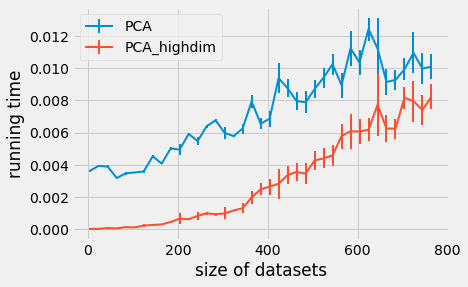

In [24]:
#可视化
fig,axe=plt.subplots()
axe.set(xlabel='size of datasets',ylabel='running time')
bar=axe.errorbar(time_1[:,0],time_1[:,1],time_2[:,2],label="PCA",linewidth=2)
axe.errorbar(time_2[:,0],time_2[:,1],time_2[:,2],label="PCA_highdim",linewidth=2)
axe.legend();

In [26]:
times_0=[]
times_1=[]

for size in np.arange(4,784,step=100):
    XX=X_[:size]
    mu,sigma=time(lambda:PCA(XX,2))
    times_0.append((size,mu,sigma))
    mu,sigma=time(lambda:PCA_highdim(XX,2))
    times_1.append((size,mu,sigma))
    
times_0=np.asarray(times_0)
times_1=np.asarray(times_1)


In [27]:
%time X_.T@X_
%time X@X_.T

Wall time: 15 ms
Wall time: 26.9 ms


array([[155.39477214,  34.00438299, -51.66524868, ...,  19.31080633,
        -19.48143647,  -7.54289044],
       [ 28.07717131, 161.92619365, -55.97194459, ...,  64.63110983,
          5.38881534, -20.58278502],
       [ -7.30407011,  -5.68355434, 229.43966471, ...,  17.28186216,
        -18.26020822,   2.71159192],
       ...,
       [ 12.7153025 ,  63.96281768, -33.67482024, ..., 175.14412827,
        -30.43927197,  34.04834091],
       [  4.89522189,  35.69268539, -38.24472842, ...,   0.53289023,
        114.97001281,   3.43667687],
       [ -1.68720204,  -8.79988493, -35.79389824, ...,  46.49953314,
        -15.0842931 , 151.03098159]])

<bound method Axes.legend of <AxesSubplot:xlabel='#(datapoints)', ylabel='running time'>>

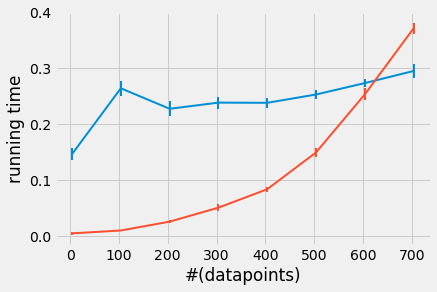

In [28]:
fit,axe=plt.subplots()
axe.set(xlabel='#(datapoints)',ylabel='running time')
axe.errorbar(times_0[:,0],times_0[:,1],times_0[:,2],label="PCA",linewidth=2)
axe.errorbar(times_1[:,0],times_1[:,1],times_1[:,2],label="PCA_highdim",linewidth=2)
axe.legend
            